# $\mathsf{CosmoFlow}$ Time-dependent Couplings

<div class="alert alert-block alert-info"> Please reach out to the developers if you have questions! Your questions and feedback are very valuable to us. </div>

In [1]:
# Import the standard Python packages
import numpy as np
import matplotlib.pyplot as plt

# Import CosmoFlow modules (they must be located in the same parent folder as this notebook)
from Parameters import parameters
from Theory import theory
from Solver import solver

In [2]:
# Define the numerical i\epsilon prescription
def adiabatic(N_load, DeltaN, N_exit):
    return (np.tanh((N_load - N_exit + DeltaN - 1)/0.1) + 1)/2

In [3]:
def feature(k, g, delta_g, sigma, N_star, omega):
    n = 100000 # Number of points for the parameter evaluation
    N_load = np.linspace(-10, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 4 # Number of e-folds before horizon crossing
    N_exit = np.log(k) # Horizon exit for a mode
    
    # Time dependence
    time_dependence = np.exp(-(N_load - N_star)**2/(2*sigma**2)) * np.cos(omega*N_load) # oscillatory signal modulated by a localised Gaussian
    
    # Theory 
    g_load = (g*np.ones(n) + delta_g*time_dependence) * adiabatic(N_load, DeltaN, N_exit) # Cubic coupling constant
    H_load = np.ones(n) # Hubble scale

    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, g_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 1 # Number of fields
    Rtol, Atol = 1e-4, 1e-180 # Relative and absolute tolerance of the integrator
    Ni, Nf = N_exit - DeltaN, 20 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    k1, k2, k3 = k, k, k # Kinematic configuration for 3-pt function (here equilateral)

    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    
    three_pt = f[6][0, 0, 0][-1]
    return three_pt



In [4]:
from joblib import Parallel, delayed # Needed for parallelisation
import time # Record the running time

def process(i):
    return feature(k = k[i], g = g, delta_g = delta_g, sigma = sigma, N_star = N_star, omega = omega)

n_pt = 300
k = np.logspace(-1, 1, n_pt)

### Varying frequency

In [12]:
omega = 5
g, delta_g, sigma, N_star = 1, 0.1, 1, 0

# Run 3pt correlator
start_time = time.time() # Start recording runtime
X = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n_pt)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

# Save file
np.save("three_pt_omega5.npy", X)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


--- 152.1476709842682 seconds ---


In [14]:
omega = 10
g, delta_g, sigma, N_star = 1, 0.1, 1, 0

# Run 3pt correlator
start_time = time.time() # Start recording runtime
X = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n_pt)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

# Save file
np.save("three_pt_omega10.npy", X)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


--- 149.4657552242279 seconds ---


### Varying width

In [31]:
sigma = 1
g, delta_g, omega, N_star = 1, 0.1, 10, 0

# Run 3pt correlator
start_time = time.time() # Start recording runtime
X = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n_pt)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

# Save file
np.save("three_pt_sigma1.npy", X)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


--- 151.55909180641174 seconds ---


In [32]:
sigma = 5
g, delta_g, omega, N_star = 1, 0.1, 10, 0

# Run 3pt correlator
start_time = time.time() # Start recording runtime
X = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n_pt)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

# Save file
np.save("three_pt_sigma5.npy", X)

--- 153.74312806129456 seconds ---


## Figures

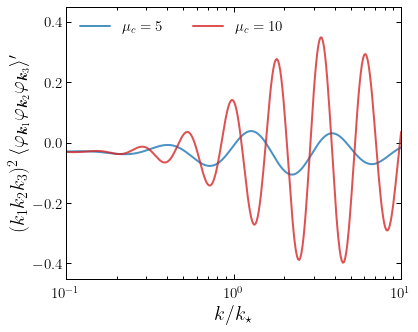

In [35]:
X1 = np.load("three_pt_omega5.npy")
X2 = np.load("three_pt_omega10.npy")

plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import figure style
plt.style.use('sty1.mplstyle')

# Define figure
fig = plt.figure()
ax = fig.add_subplot()

ax.set_xscale("log")

# Axis limits
ax.set_xlim([1e-1, 1e1])
ax.set_ylim([-0.45, 0.45])
ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])

# Plot rescaled 3pt correlator
ax.semilogx(k, k**6 * X1, color = "C0", alpha = 0.8, label = "$\mu_c = 5$")
ax.semilogx(k, k**6 * X2, color = "C1", alpha = 0.8, label = "$\mu_c = 10$")

# Labels
ax.set_xlabel(r"$k/k_\star$")
ax.set_ylabel(r"$(k_1k_2k_3)^2\,\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$")
ax.legend(ncol = 2, loc = 2)

# Save figure
plt.savefig('TimeDependentCouplings_frequency.pdf', bbox_inches = "tight")

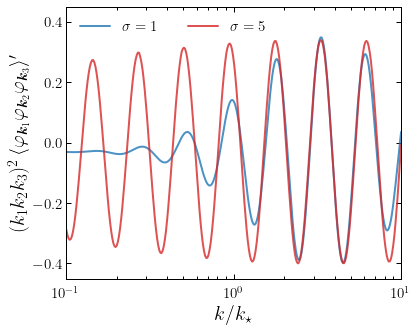

In [33]:
X3 = np.load("three_pt_sigma1.npy")
X4 = np.load("three_pt_sigma5.npy")

plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import figure style
plt.style.use('sty1.mplstyle')

# Define figure
fig = plt.figure()
ax = fig.add_subplot()

ax.set_xscale("log")

# Axis limits
ax.set_xlim([1e-1, 1e1])
ax.set_ylim([-0.45, 0.45])
ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])

# Plot rescaled 3pt correlator
ax.semilogx(k, k**6 * X3, color = "C0", alpha = 0.8, label = "$\sigma = 1$")
ax.semilogx(k, k**6 * X4, color = "C1", alpha = 0.8, label = "$\sigma = 5$")

# Labels
ax.set_xlabel(r"$k/k_\star$")
ax.set_ylabel(r"$(k_1k_2k_3)^2\,\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$")
ax.legend(ncol = 2, loc = 2)

# Save figure
plt.savefig('TimeDependentCouplings_width.pdf', bbox_inches = "tight")